### what is CLTV? 
Total monetary value of transactions/purchases made by a customer with business over the time. 

####  CLTV = [ ( Avg Sales * Frequency ) / churn ] * Profit Margin

#### 
    Avg Sales = Total Sales / Total No.of Orders
    Purchase Frequency = Total No.of Orders / Total Unique customers
    Churn = 1 - Retention Rate
    Profit Margin = Based on business ( ~ 5% ) 


In [1]:
!pip3 install pandas
!pip3 install lifetimes
!pip3 install matplotlib

In [2]:
import pandas as pd
import lifetimes
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("Online Retail.csv")

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [5]:
data["TotalSales"] = data['Quantity'].multiply(data['UnitPrice'])

#####  Summary table of RFM: Recency Frequency Monetary Value

In [6]:
summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "TotalSales")

In [7]:
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,234.0,0.0000
1,12347.0,4.0,238.0,276.0,578.8675
2,12348.0,2.0,110.0,267.0,629.9000
3,12350.0,0.0,0.0,219.0,0.0000
4,12352.0,3.0,34.0,205.0,101.5600


###### If Frequency , Recency = 0 then they are one time buyers. 

In [8]:
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)

In [9]:
one_time_buyers

36.61

#### BG/NBD model: Beta Geometric / Negative Binomial Distribution model



In [10]:

bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 3412 subjects, a: 0.05, alpha: 50.50, b: 0.73, r: 0.74>

In [11]:

# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.743626,0.027644,0.689444,0.797808
alpha,50.499923,2.324567,45.943771,55.056075
a,0.052469,0.014391,0.024262,0.080676
b,0.726278,0.239211,0.257424,1.195132


###### Probability of Customer Alive

In [12]:
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,234.0,0.0000,1.000000
1,12347.0,4.0,238.0,276.0,578.8675,0.975301
2,12348.0,2.0,110.0,267.0,629.9000,0.835048
3,12350.0,0.0,0.0,219.0,0.0000,1.000000
4,12352.0,3.0,34.0,205.0,101.5600,0.452208
5,12353.0,0.0,0.0,113.0,0.0000,1.000000
6,12354.0,0.0,0.0,141.0,0.0000,1.000000
7,12355.0,0.0,0.0,123.0,0.0000,1.000000
8,12356.0,1.0,80.0,234.0,481.4600,0.780536
9,12358.0,0.0,0.0,59.0,0.0000,1.000000


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

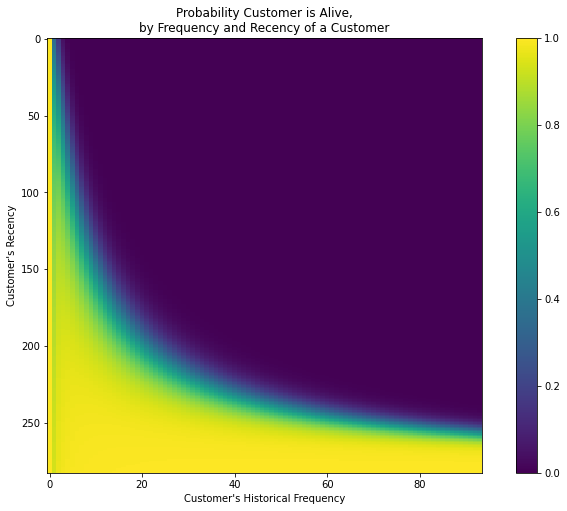

In [13]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

###### Future transactionsfor next 30 days

In [14]:
t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1513,14911.0,93.0,282.0,282.0,769.892258,0.999434,8.43
1,3153,17841.0,76.0,282.0,282.0,301.006842,0.999308,6.90
2,259,12748.0,73.0,282.0,282.0,186.745890,0.999279,6.63
3,1338,14606.0,66.0,280.0,282.0,135.932576,0.998807,6.00
4,1748,15311.0,64.0,279.0,282.0,696.724531,0.998522,5.82
5,452,13089.0,62.0,270.0,278.0,664.716129,0.996023,5.69
6,2362,16422.0,54.0,270.0,278.0,521.122037,0.996248,4.97
7,383,12971.0,52.0,280.0,281.0,150.657115,0.998812,4.76
8,1294,14527.0,44.0,275.0,282.0,104.994545,0.996901,4.02
9,1672,15189.0,37.0,241.0,241.0,318.757838,0.998573,3.87


##### frequency Vs monetary_value


In [15]:
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary

(2163, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,4.0,238.0,276.0,578.8675,0.975301,0.42
2,12348.0,2.0,110.0,267.0,629.9000,0.835048,0.22
4,12352.0,3.0,34.0,205.0,101.5600,0.452208,0.20
8,12356.0,1.0,80.0,234.0,481.4600,0.780536,0.14
10,12359.0,3.0,142.0,240.0,970.8100,0.917582,0.35
...,...,...,...,...,...,...,...
3403,18270.0,1.0,26.0,175.0,-44.2000,0.677606,0.16
3404,18272.0,4.0,133.0,155.0,437.9825,0.976473,0.67
3405,18273.0,1.0,162.0,166.0,102.0000,0.930551,0.22
3409,18282.0,1.0,4.0,35.0,-1.4500,0.863247,0.52


In [16]:
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.178032
monetary_value,0.178032,1.000000


In [17]:
return_customers_summary = return_customers_summary[return_customers_summary["monetary_value"]>0]
return_customers_summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,4.0,238.0,276.0,578.8675,0.975301,0.42
2,12348.0,2.0,110.0,267.0,629.9000,0.835048,0.22
4,12352.0,3.0,34.0,205.0,101.5600,0.452208,0.20
8,12356.0,1.0,80.0,234.0,481.4600,0.780536,0.14
10,12359.0,3.0,142.0,240.0,970.8100,0.917582,0.35
...,...,...,...,...,...,...,...
3399,18263.0,1.0,97.0,161.0,503.8000,0.880724,0.22
3402,18269.0,1.0,8.0,275.0,168.6000,0.409763,0.07
3404,18272.0,4.0,133.0,155.0,437.9825,0.976473,0.67
3405,18273.0,1.0,162.0,166.0,102.0000,0.930551,0.22


##### Gamma- Gamma model

In [18]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1995 subjects, p: 4.23, q: 0.58, v: 12.04>

In [19]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.234892,0.153507,3.934018,4.535766
q,0.583589,0.016823,0.550616,0.616561
v,12.035248,0.351146,11.347001,12.723495


#### Expected profit

In [20]:
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1,12347.0,4.0,238.0,276.0,578.8675,0.975301,0.42,596.540575
2,12348.0,2.0,110.0,267.0,629.9000,0.835048,0.22,668.798671
4,12352.0,3.0,34.0,205.0,101.5600,0.452208,0.20,109.149250
8,12356.0,1.0,80.0,234.0,481.4600,0.780536,0.14,547.311687
10,12359.0,3.0,142.0,240.0,970.8100,0.917582,0.35,1007.855450


###### Evaluation expected average value and the actual average value in the data to make sure the values are good


In [21]:
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 364.9440390013833
Actual Average Sales: 342.2106000090125


In [22]:
# Predicting Customer Lifetime Value for the next 30 days
summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               summary['frequency'],
                                                               summary['recency'],
                                                               summary['T'],
                                                               summary['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
1,12347.0,4.0,238.0,276.0,578.8675,0.975301,0.42,596.540575,250.374949
2,12348.0,2.0,110.0,267.0,629.9000,0.835048,0.22,668.798671,142.886938
4,12352.0,3.0,34.0,205.0,101.5600,0.452208,0.20,109.149250,21.402098
8,12356.0,1.0,80.0,234.0,481.4600,0.780536,0.14,547.311687,77.451234
10,12359.0,3.0,142.0,240.0,970.8100,0.917582,0.35,1007.855450,352.834058


In [23]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
1,12347.0,4.0,238.0,276.0,578.8675,0.975301,0.42,596.540575,250.374949,250.547041
2,12348.0,2.0,110.0,267.0,629.9000,0.835048,0.22,668.798671,142.886938,147.135708
4,12352.0,3.0,34.0,205.0,101.5600,0.452208,0.20,109.149250,21.402098,21.829850
8,12356.0,1.0,80.0,234.0,481.4600,0.780536,0.14,547.311687,77.451234,76.623636
10,12359.0,3.0,142.0,240.0,970.8100,0.917582,0.35,1007.855450,352.834058,352.749408


In [24]:

profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,4.0,238.0,276.0,578.8675,0.975301,0.42,596.540575,250.374949,250.547041,12.518747
2,12348.0,2.0,110.0,267.0,629.9000,0.835048,0.22,668.798671,142.886938,147.135708,7.144347
4,12352.0,3.0,34.0,205.0,101.5600,0.452208,0.20,109.149250,21.402098,21.829850,1.070105
8,12356.0,1.0,80.0,234.0,481.4600,0.780536,0.14,547.311687,77.451234,76.623636,3.872562
10,12359.0,3.0,142.0,240.0,970.8100,0.917582,0.35,1007.855450,352.834058,352.749408,17.641703
